In [14]:
import numpy as np
import pandas as pd
import pandas as pd

import json
from Config.helpers import PyJSON

In [15]:
with open("Config/config.json", "r") as f:
    # CONFIG = Struct(json.load(f))
    CONFIG = PyJSON(json.load(f))
f.close()

In [16]:
## Load the data from the CSV file
train_data = pd.read_csv('./Dataset/train7.csv')
test_data = pd.read_csv('./Dataset/DriveCycle7-test-100.csv')
validation_data = pd.read_csv('./Dataset/test.csv')        # To check the performance of ML model

def dataDimention(data):
    freq = CONFIG.PreProcessing.frequency
    data1 = data.iloc[::int(100/freq)]
    return data1

def FeatureSelection(drop_column, data):
    data = dataDimention(data)
    return data.drop(drop_column, axis=1)



In [17]:
timesteps = CONFIG.PreProcessing.window_size   # dataset have 100 ms sample rate for each sec we create 10 dataset a input

def Preprocessing(train_data, test_data, nom_data):
    #normalise test/train
    for i in range(train_data.shape[1]):
        for j in range(test_data.shape[1]):
            if train_data.columns[i] == test_data.columns[j]:
                maxi = train_data.iloc[:,i].max()
                mini = train_data.iloc[:,i].min()   #,test_data.iloc[:,i].max())
                train_data.iloc[:,i] = (train_data.iloc[:,i]-mini)/(maxi-mini)
                test_data.iloc[:,j] = (test_data.iloc[:,j]-mini)/(maxi-mini)
                nom_data.iloc[:,j] = (nom_data.iloc[:,j]-mini)/(maxi-mini)
    
    #Freature Selection
    drop_column = CONFIG.PreProcessing.delete_features     
    train_data = FeatureSelection(drop_column,train_data)
    test_data = FeatureSelection(drop_column,test_data)
    nom_data = FeatureSelection(drop_column,nom_data)
    train_dim = train_data.shape[1]

    ## Reshape the data for the VAE model (window segmentation)
    x_train = np.reshape(np.array(train_data), (-1, timesteps, train_dim))
    x_test = np.reshape(np.array(test_data), (-1, timesteps, train_dim))
    nom = np.reshape(np.array(nom_data), (-1, timesteps, train_dim))

    return x_train, x_test, nom, train_dim

x_train, x_test, validation, train_dim = Preprocessing(train_data, test_data, validation_data)
print('Data preparation for training and testing is done')

Data preparation for training and testing is done


In [1]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, Lambda, TimeDistributed, Conv1D, Conv1DTranspose
from tensorflow.keras.models import Model
#from tensorflow.keras.losses import mse, binary_crossentropy
#from tensorflow.keras.utils import plot_model
#from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow_probability as tfp
import torch


## For Plots font size. 
font = {'family' : "serif",
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)

In [19]:
CONFIG.settings.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Selected device: {}".format(CONFIG.settings.device))

torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True

Selected device: cpu


In [20]:
# hyperparameters
batch = CONFIG.Models.lstm_VAE.batch_size
epoch = CONFIG.Models.lstm_VAE.epoch
latent_dim = CONFIG.Models.lstm_VAE.latent_dim
lstm1 = CONFIG.Models.lstm_VAE.layers.Lstm1
lstm2 = CONFIG.Models.lstm_VAE.layers.Lstm2
act1 = CONFIG.Models.lstm_VAE.activation.act1
act2 = CONFIG.Models.lstm_VAE.activation.act2

In [21]:
# Sampling function
def sampling(args):
  z_mean, z_log_var = args
  epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim)) # Random noise
  return z_mean + tf.exp(0.5 * z_log_var) * epsilon # Reparameterization trick

In [72]:
# Define the Encoder architecture
inputs = Input(shape=(timesteps, train_dim), name='encoder_input')
#x = LSTM(32, activation=act1, return_sequences=True)(inputs)
x = Conv1D(filters=16, kernel_size=4, padding = 'same', activation = act1)(inputs)
x = LSTM(8, activation=act1, return_sequences=False)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sample z from the latent space
z = sampling([z_mean, z_log_var])
encoder = Model(inputs,[z_mean, z_log_var, z], name = "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 25, 14)]     0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 25, 16)       912         ['encoder_input[0][0]']          
                                                                                                  
 lstm_23 (LSTM)                 (None, 8)            800         ['conv1d_9[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 4)            36          ['lstm_23[0][0]']                
                                                                                            

In [73]:
# Define the decoder architecture
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = RepeatVector(timesteps)(decoder_input)
x = x = LSTM(8, activation=act1, return_sequences=True)(x)
x = Conv1DTranspose(filters=16, kernel_size=5, padding = 'same', activation = act1)(x)
#x = RepeatVector(timesteps)(x)
#x = LSTM(32, activation=act1, return_sequences=True)(x)
outputs = TimeDistributed(Dense(train_dim, activation=act2), name='decoder_output')(x)

#Decoder output
decoder = Model(decoder_input, outputs, name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 4)]               0         
                                                                 
 repeat_vector_6 (RepeatVect  (None, 25, 4)            0         
 or)                                                             
                                                                 
 lstm_24 (LSTM)              (None, 25, 8)             416       
                                                                 
 conv1d_transpose_6 (Conv1DT  (None, 25, 16)           656       
 ranspose)                                                       
                                                                 
 decoder_output (TimeDistrib  (None, 25, 14)           238       
 uted)                                                           
                                                           

In [74]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        output  = self.decoder(z)
        return output

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_sum(
                    keras.losses.mean_absolute_error(data, reconstruction)
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, validation_data):
        _, _, z = self.encoder(validation_data)
        reconstruction = self.decoder(z)
        validation_loss = tf.reduce_sum(
            keras.losses.mean_absolute_error(validation_data, reconstruction)
        )
        return {
            "reconstruction_loss": validation_loss
        }

In [75]:
def plot_validation_moment(history):
    _, ax = plt.subplots(figsize=(18, 8), dpi=80)
    ax.plot(history['val_reconstruction_loss'], 'red', label='Validation loss', linewidth=1)
    ax.set_title('Losses over epochs')
    ax.set_ylabel('Validation loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    ax.grid(linestyle='-.')
    plt.savefig('./Results/Vali loss.png', bbox_inches='tight')

def plot_loss_moment(history):
    _, ax = plt.subplots(figsize=(18, 8), dpi=80)
    ax.plot(history['loss'], 'blue', label='Total loss', linewidth=1)
    ax.plot(history['reconstruction_loss'], 'red', label='Reconstruction loss', linewidth=1)
    ax.set_title('Losses over epochs')
    ax.set_ylabel('Total loss and \n Reconstruction loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    ax.grid(linestyle='-.')
    plt.savefig('./Results/Recon loss.png', bbox_inches='tight')
    plot_validation_moment(history)


Epoch 1/100
378/378 [==============================] - 11s 22ms/step - loss: 635.7126 - reconstruction_loss: 520.5847 - kl_loss: 2.4859 - val_reconstruction_loss: 51.3545 - lr: 0.0010
Epoch 2/100
378/378 [==============================] - 8s 22ms/step - loss: 247.1322 - reconstruction_loss: 238.1819 - kl_loss: 5.1694 - val_reconstruction_loss: 32.5884 - lr: 0.0010
Epoch 3/100
378/378 [==============================] - 9s 23ms/step - loss: 185.3701 - reconstruction_loss: 184.3372 - kl_loss: 6.3473 - val_reconstruction_loss: 31.6088 - lr: 0.0010
Epoch 4/100
378/378 [==============================] - 9s 25ms/step - loss: 163.6479 - reconstruction_loss: 164.6284 - kl_loss: 7.2936 - val_reconstruction_loss: 34.1210 - lr: 0.0010
Epoch 5/100
378/378 [==============================] - 9s 23ms/step - loss: 152.7656 - reconstruction_loss: 155.5157 - kl_loss: 7.7453 - val_reconstruction_loss: 38.6761 - lr: 0.0010
Epoch 6/100
378/378 [==============================] - 9s 24ms/step - loss: 146.5957

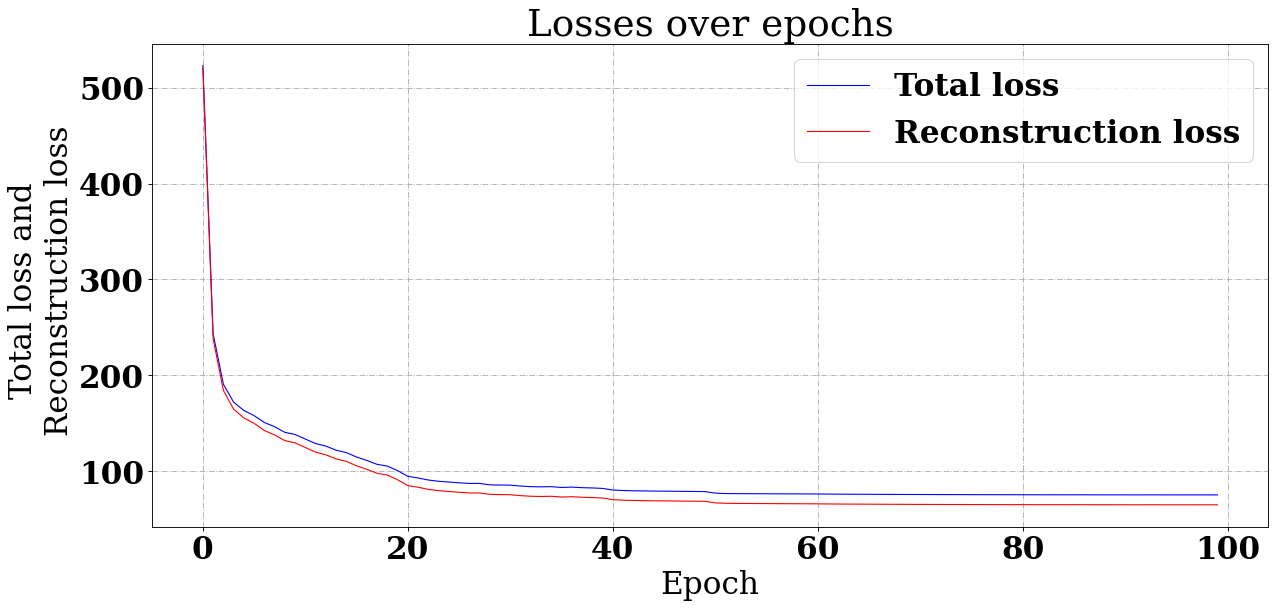

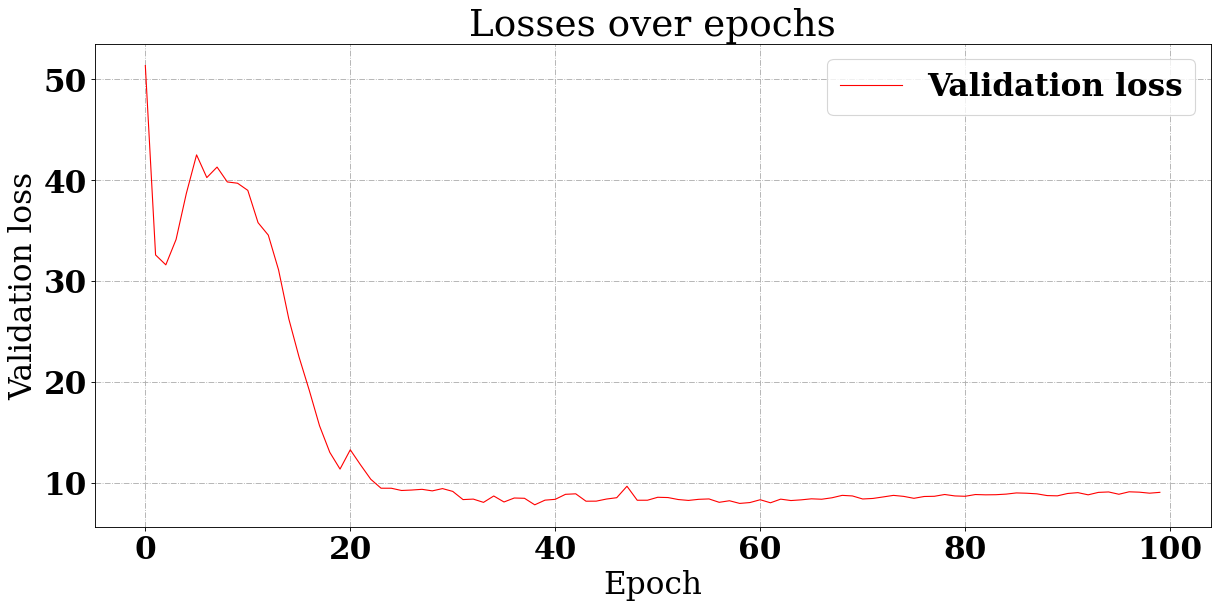

In [76]:
# Train the LSTM-VAE

def scheduler(epoch, lr):               
    if epoch < 60:
        if epoch == 20:
            return lr/2
        elif epoch == 40:
            return lr/2
        elif epoch == 50:
            return lr/5
        return lr 
    else:
        return lr * tf.math.exp(-0.1)

if CONFIG.Models.lstm_VAE.train == True:
    vae = VAE(encoder, decoder)
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    vae.compile(optimizer=keras.optimizers.Adam())
    history = vae.fit(x_train, epochs=epoch, callbacks=[callback],shuffle=False, batch_size=batch, validation_data = (validation,)).history
    plot_loss_moment(history)       #history.loss

if CONFIG.Models.lstm_VAE.train == False:
    encoder_new = keras.models.load_model('./Model/Lstm-VAE/{}Hz_{}win_7DC/encoder'.format(CONFIG.PreProcessing.frequency,CONFIG.PreProcessing.window_size)) #Loading the encoder model
    decoder_new = keras.models.load_model('./Model/Lstm-VAE/{}Hz_{}win_7DC/decoder'.format(CONFIG.PreProcessing.frequency,CONFIG.PreProcessing.window_size)) #Loading the decoder model

    vae = VAE(encoder_new, decoder_new) #You need to have VAE class defined for this to works
    vae.compile(optimizer=keras.optimizers.Adam()) #Now we need to compile the model and we are ready to go!

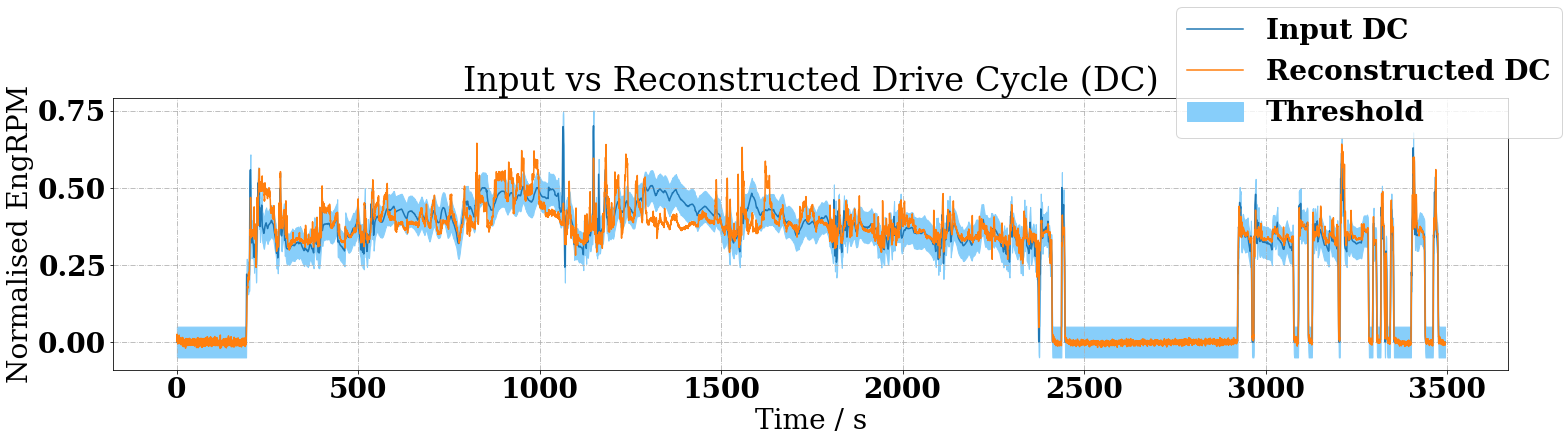

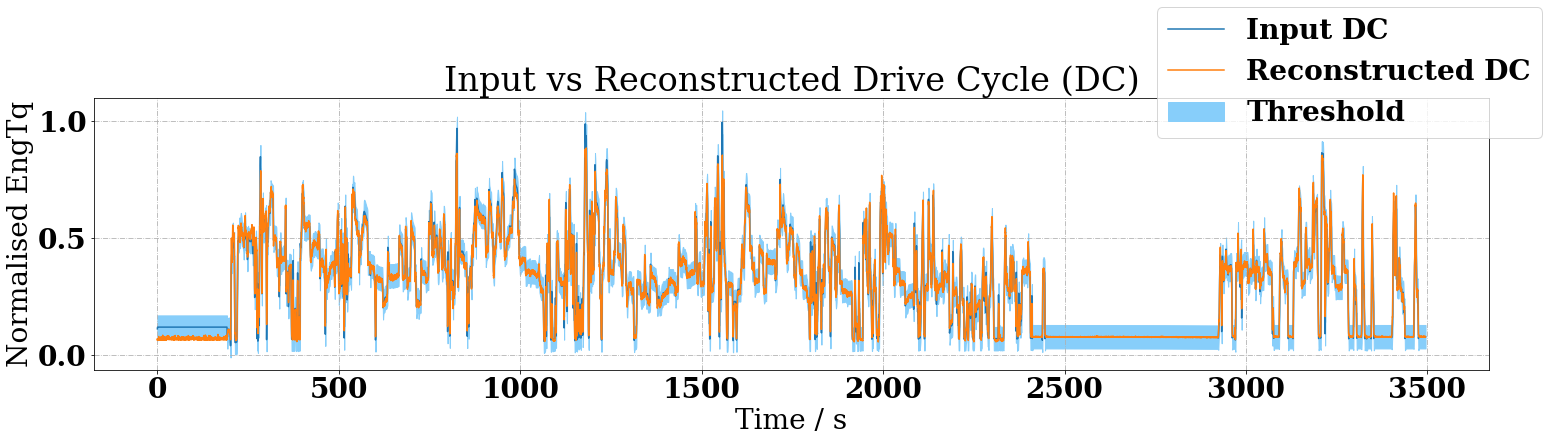

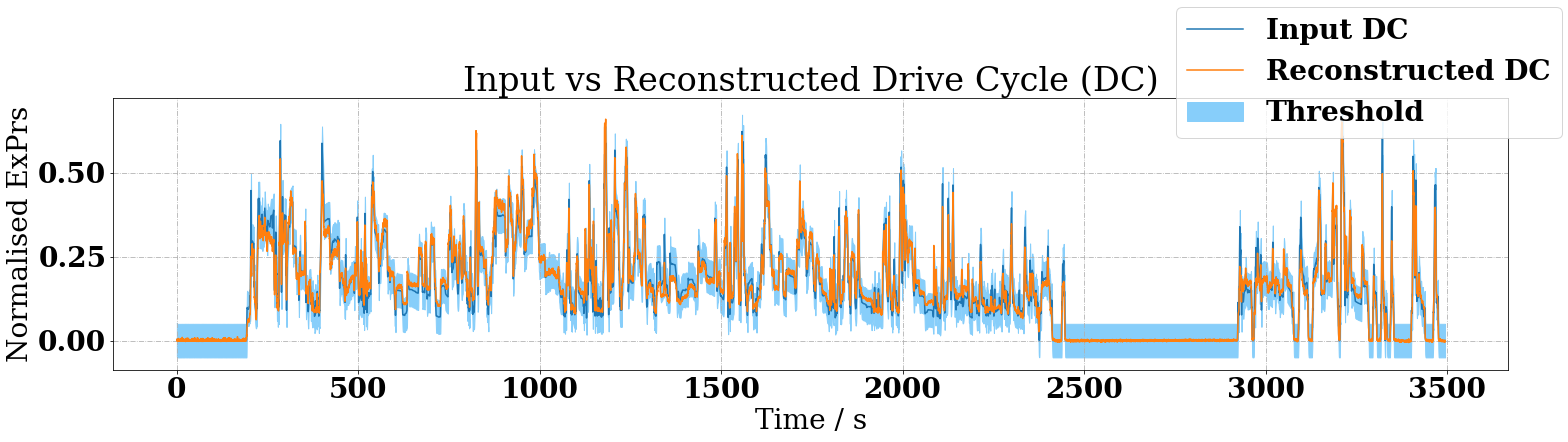

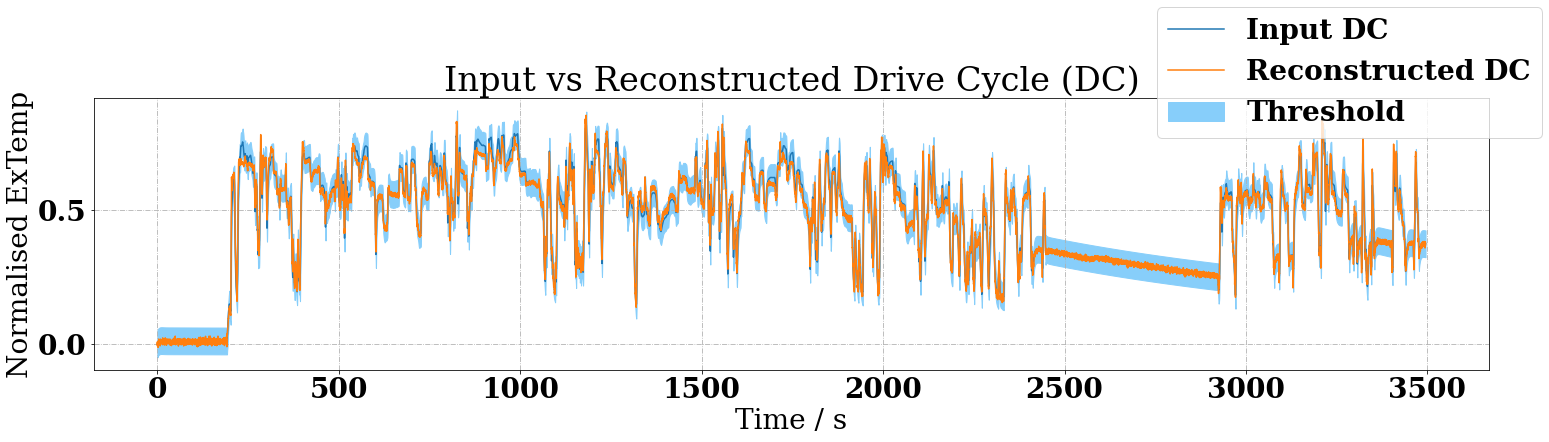

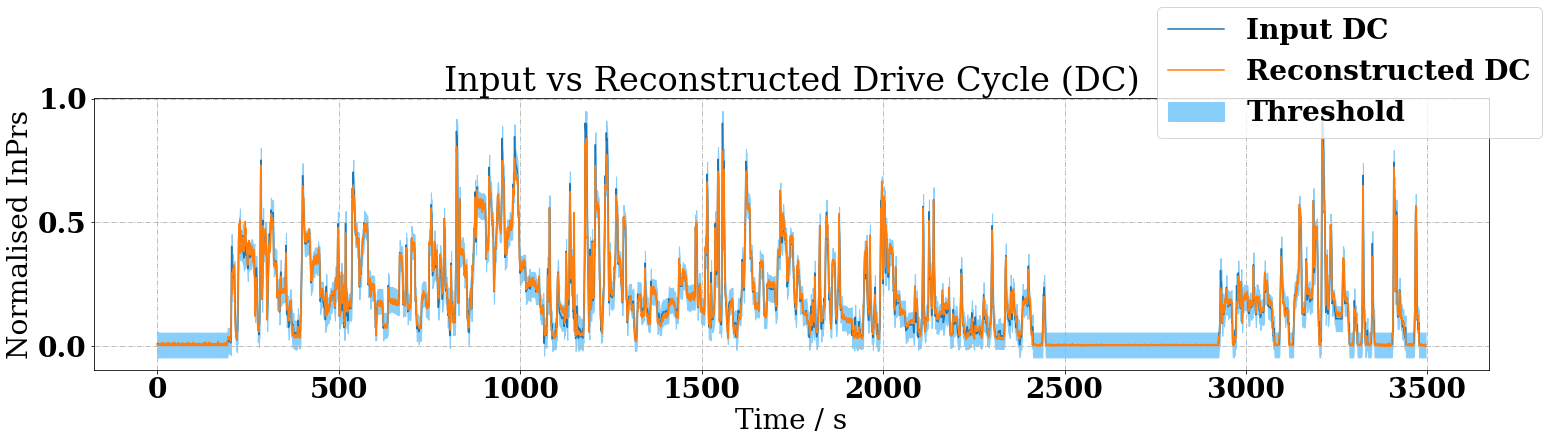

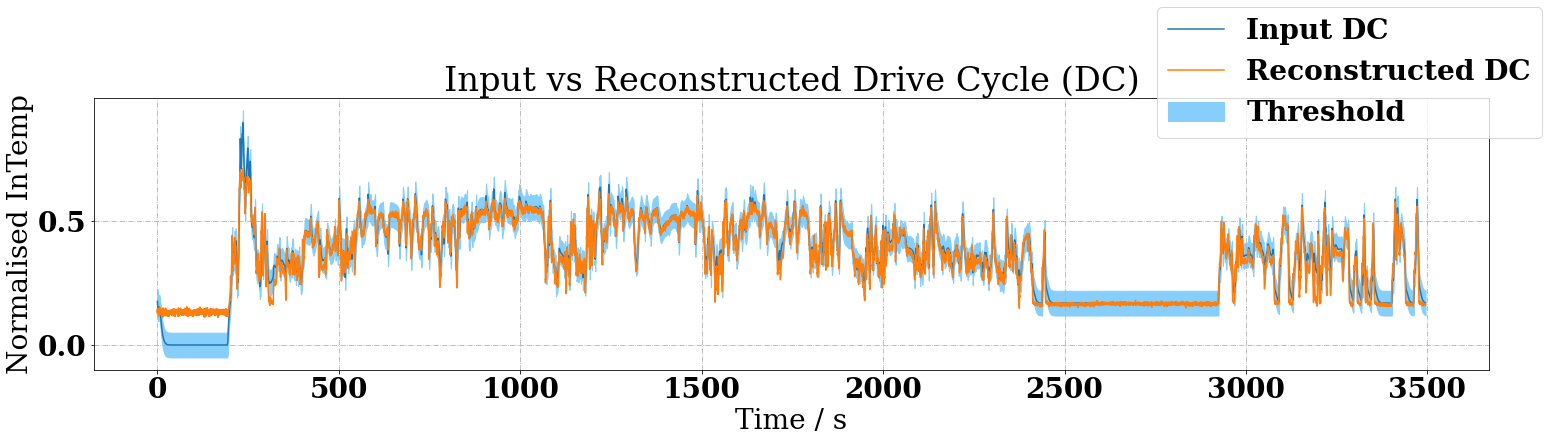

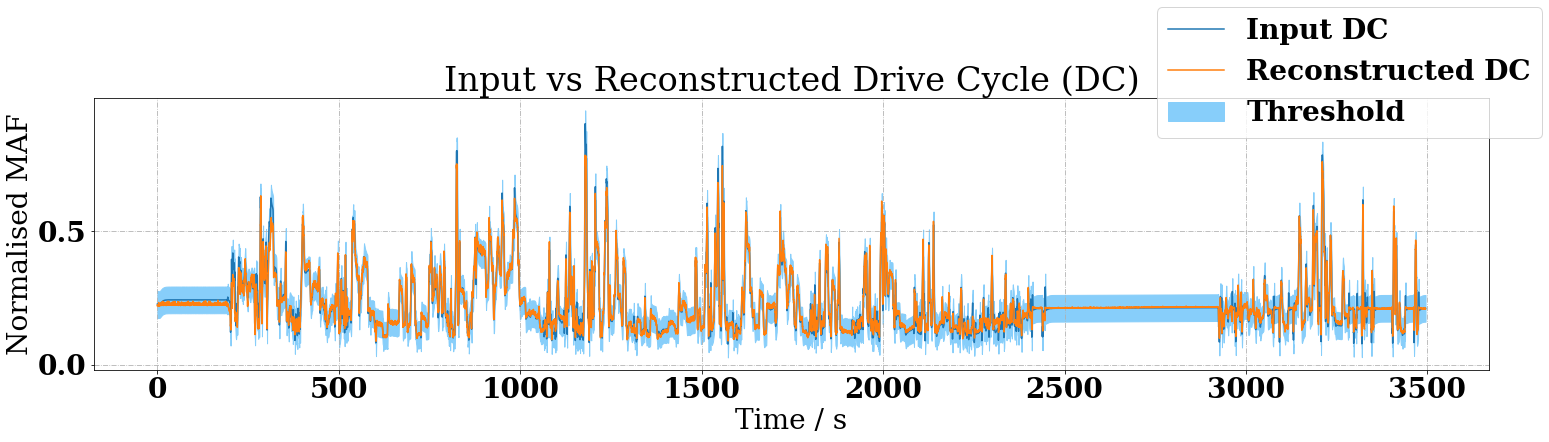

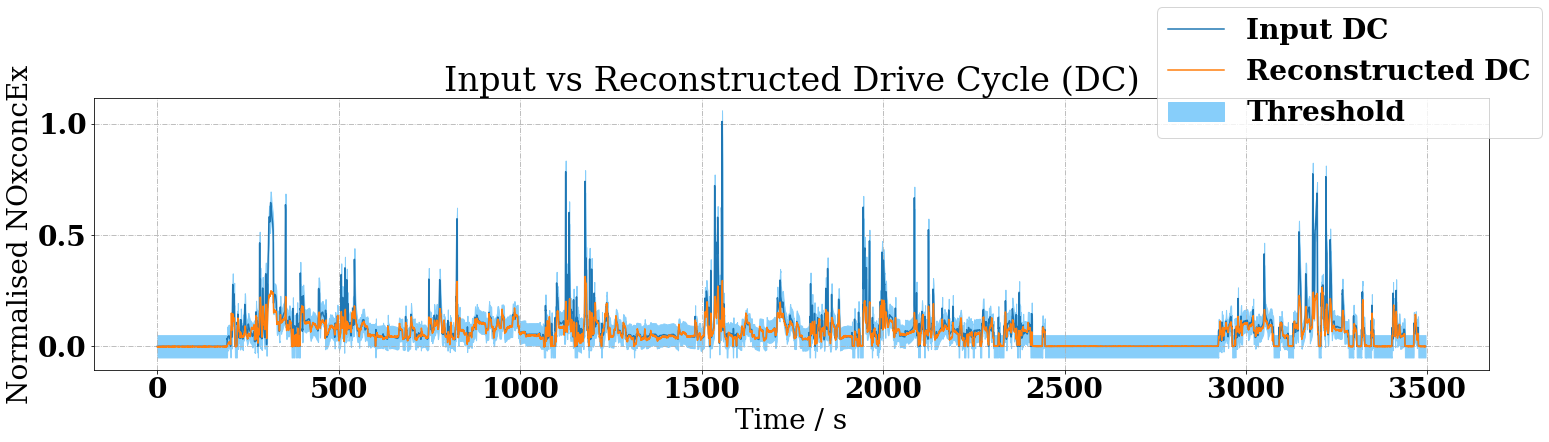

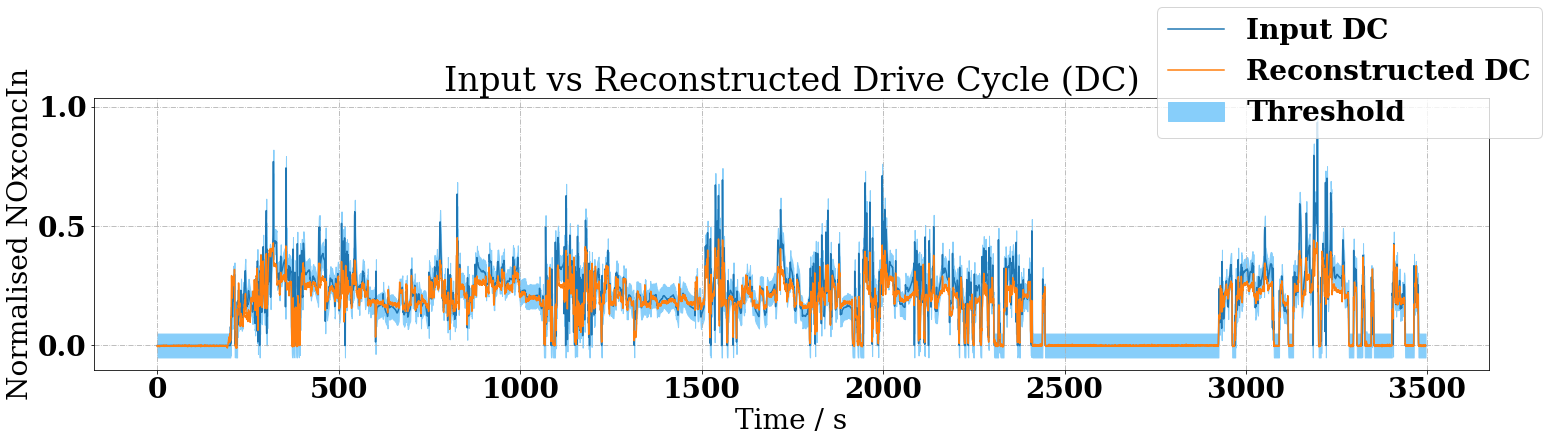

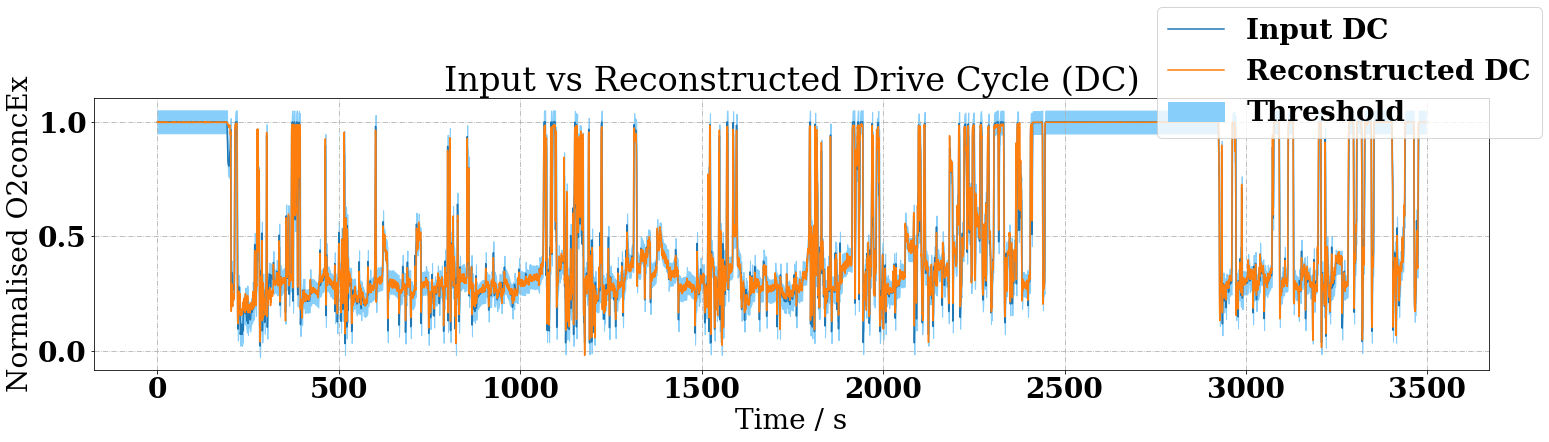

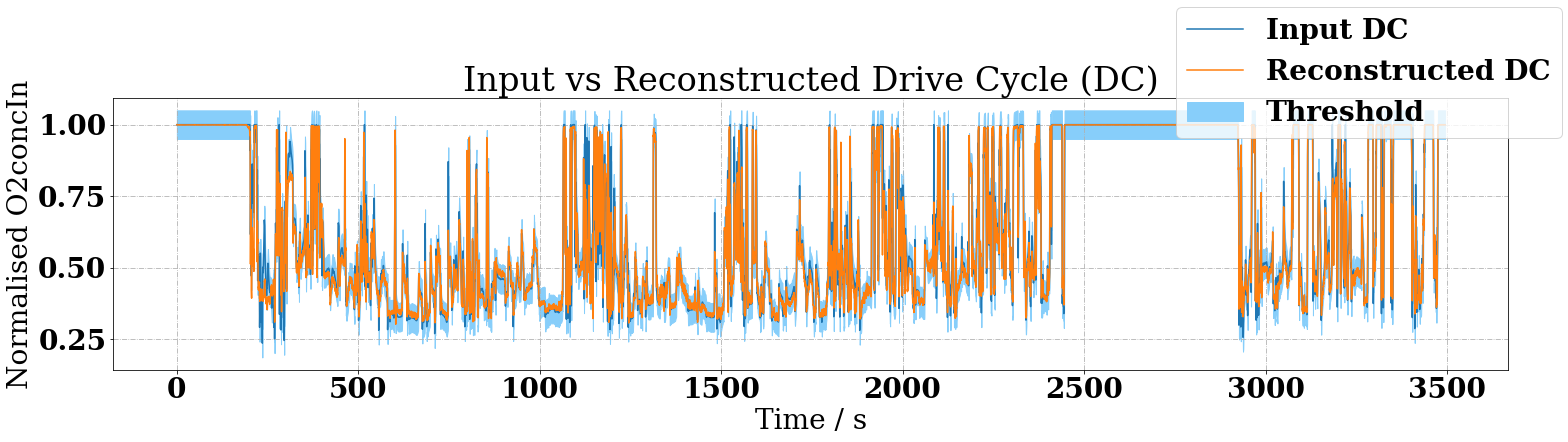

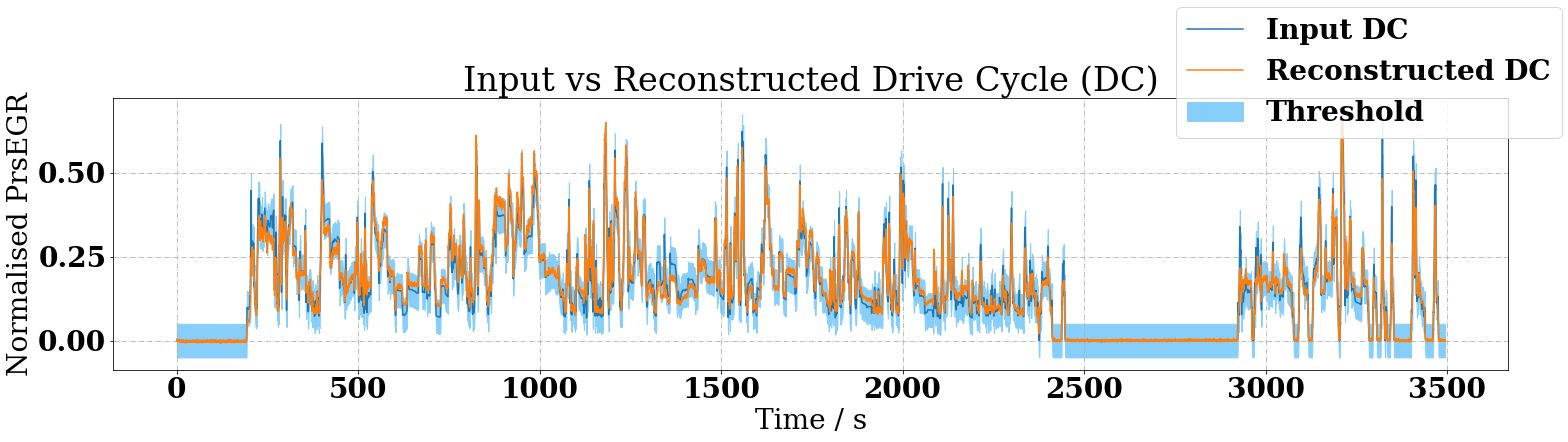

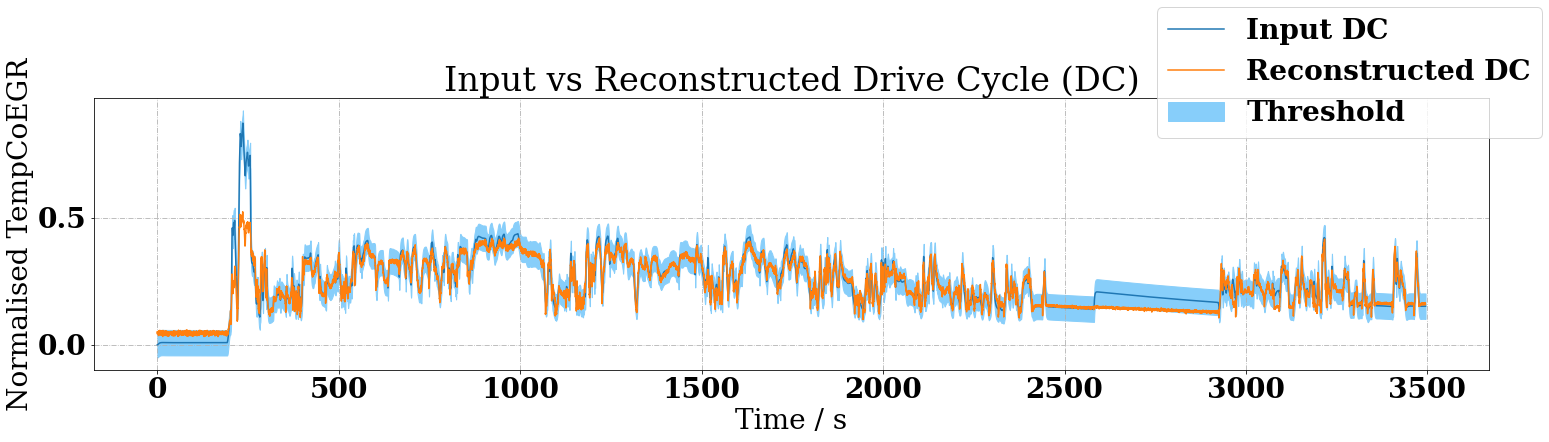

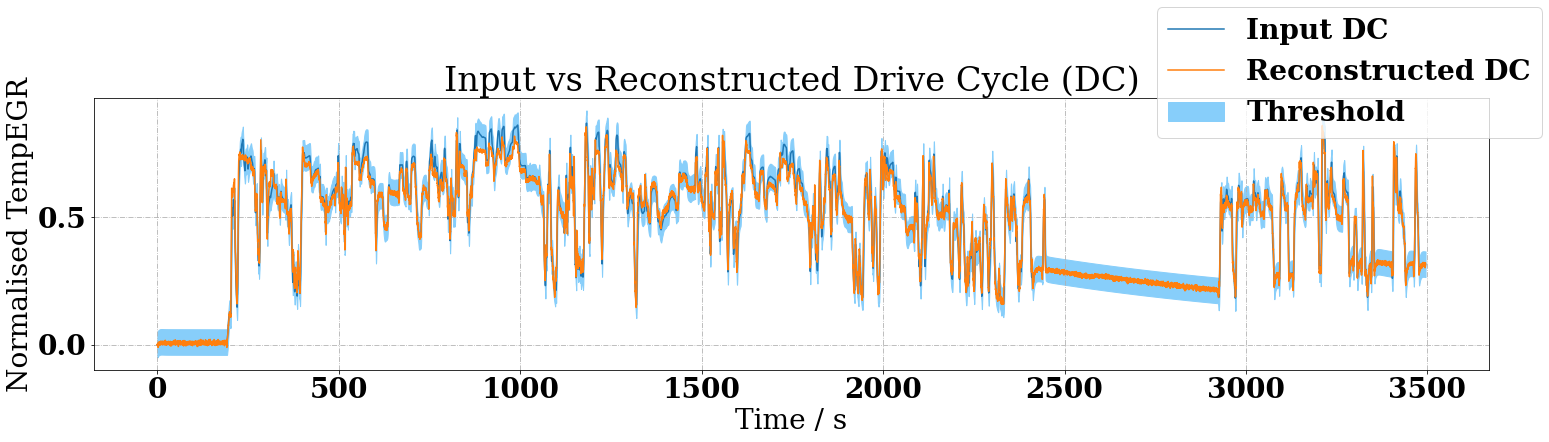

In [87]:
from scipy import signal
from scipy.stats import entropy

pred = vae.predict(x_test)

def deshape(data):
    data = np.mean(data,axis = 1)
    #data = np.reshape(data,(data.shape[0]*data.shape[1],data.shape[2]))
    return data

#pred = Noise(pred)

def Plot(d, pd, title):
    alpha = 0.05
    for i in range(d.shape[1]):
        feature = i
        plt.figure(figsize=[25,5])
        plt.plot(np.arange(0,int(len(d[:,feature])*CONFIG.PreProcessing.window_size/100),CONFIG.PreProcessing.window_size/100),d[:,feature], label = 'Input DC')
        plt.plot(np.arange(0,int(len(d[:,feature])*CONFIG.PreProcessing.window_size/100),CONFIG.PreProcessing.window_size/100),pd[:,feature], label = 'Reconstructed DC')
        plt.fill_between(np.arange(0,int(len(d[:,feature])*CONFIG.PreProcessing.window_size/100),CONFIG.PreProcessing.window_size/100) ,d[:,feature] - alpha, d[:,feature] + alpha,color='lightskyblue', label = 'Threshold')
        plt.legend(bbox_to_anchor=(0.9, 0.8),ncol=1, loc='lower center')
        plt.title(title)
        plt.grid(linestyle='-.')
        plt.xlabel('Time / s')
        plt.ylabel('Normalised {}'.format(train_data.columns[i]))
        
        #plt.savefig('./Results/DataViz/Anom_Recon_F{}_DC7.png'.format(i+1), bbox_inches='tight')
Plot(deshape(x_test), deshape(pred), 'Input vs Reconstructed Drive Cycle (DC)')


In [88]:
train_data = pd.read_csv('./Dataset/train7.csv')
nom_data = pd.read_csv('./Dataset/DriveCycle2-test-100.csv')
test_data = pd.read_csv('./Dataset/DriveCycle2-test-100.csv')
x_train, x_test, nom, _ = Preprocessing(train_data, test_data, nom_data)

## Just one feature is affected.
#x_test[:,:,5] = 0.1*x_test[:,:,5]

In [89]:
pred = vae.predict(x_test, verbose=0)
def plot_hist(data, x_test,nom):
    plt.figure(figsize=[15,10])
    plt.hist(data[:,5],color='r', bins=50, histtype='step', label='predict')
    plt.hist(x_test[:,5],color='b', bins=50, histtype='step', label='Input')
    plt.hist(nom[:,5],color='g', bins=50, histtype='step', label='Normal')
    plt.xlabel('NOx Emission')
    plt.ylabel('Number of data points')
    plt.legend()
    plt.legend(loc='upper right')
    
    epsilon = 1e-10
    hist1, bins1 = np.histogram(data[:,7], bins=100, density=True)
    hist2, bins2 = np.histogram(x_test[:,7], bins=100, density=True)

    # Compute KL Divergence between the two distributions
    #kl_divergence = entropy(hist1+epsilon, hist2+epsilon)

    # Compute JS Divergence between the two distributions
    js_divergence = (entropy(hist1, (hist1 + hist2) / 2) + entropy(hist2, (hist1 + hist2) / 2)) / 2

    #print("KL Divergence:", kl_divergence)
    print("JS Divergence:", js_divergence)
#plot_hist(deshape(pred), deshape(x_test), deshape(nom))

Nom_pred_error:  0.06920701476556233 
Anom_pred_error:  0.1404450100429643 
Actual_error:  0.22031696403097636
KL Divergence: 1.1362535825996651
JS Divergence: 0.20018618256470094


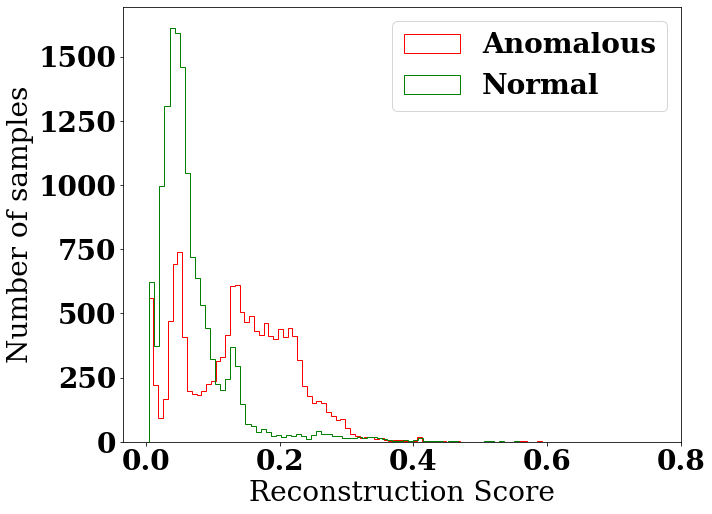

In [80]:
def Predict_LOSS(data, model):
    pred = model.predict(data, verbose=0)
    mae_loss = np.max(np.mean(np.abs(pred - data), axis=1),axis=1)
    return mae_loss

mae_loss = np.max(np.mean(np.abs(nom - x_test), axis=1),axis=1)
nom_mae_loss = Predict_LOSS(nom, vae)
test_mae_loss = Predict_LOSS(x_test, vae)
#print(f'Reconstruction error Max-threshold: {max_threshold}')

print("Nom_pred_error: ",np.mean(nom_mae_loss),"\nAnom_pred_error: ", np.mean(test_mae_loss),"\nActual_error: ", np.mean(mae_loss))


plt.figure(figsize=[10,8])
plt.hist(test_mae_loss, bins=100, histtype='step', label = 'Anomalous',color='r')
plt.hist(nom_mae_loss, bins=100, histtype='step', label = 'Normal',color='g')
#plt.hist(mae_loss, bins=50, histtype='step', label = 'Actual')
plt.xlabel('Reconstruction Score')
plt.ylabel('Number of samples')
plt.legend()

epsilon = 1e-10
hist1, bins1 = np.histogram(test_mae_loss, bins=200, density=True)
hist2, bins2 = np.histogram(nom_mae_loss, bins=200, density=True)

# Compute KL Divergence between the two distributions
kl_divergence = entropy(hist1+epsilon, hist2+epsilon)

# Compute JS Divergence between the two distributions
js_divergence = (entropy(hist1, (hist1 + hist2) / 2) + entropy(hist2, (hist1 + hist2) / 2)) / 2

print("KL Divergence:", kl_divergence)
print("JS Divergence:", js_divergence)

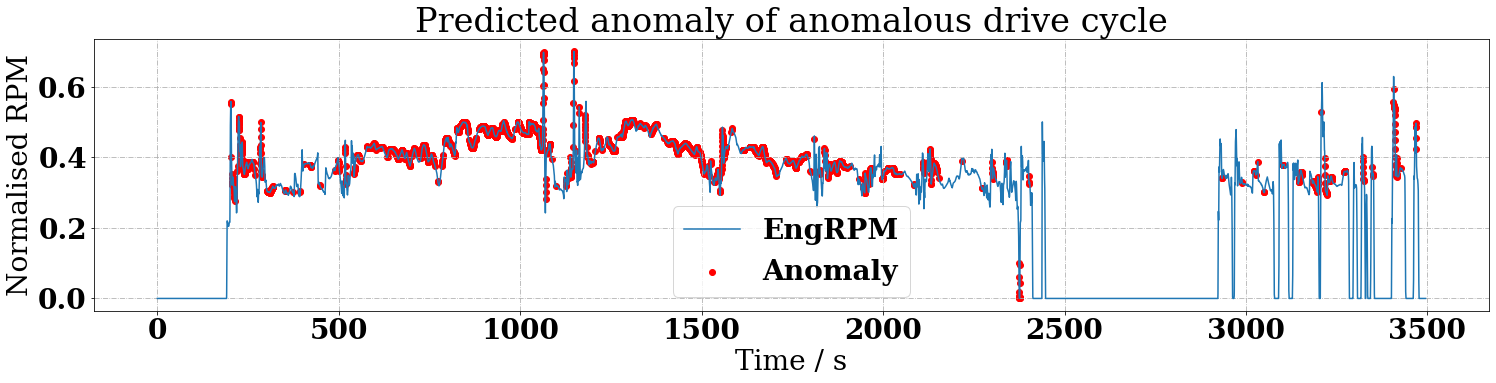

Anomalous DC anomalous behaviour:  24.248927038626608 %
Anomalous DC normal behaviour:  75.7510729613734 %


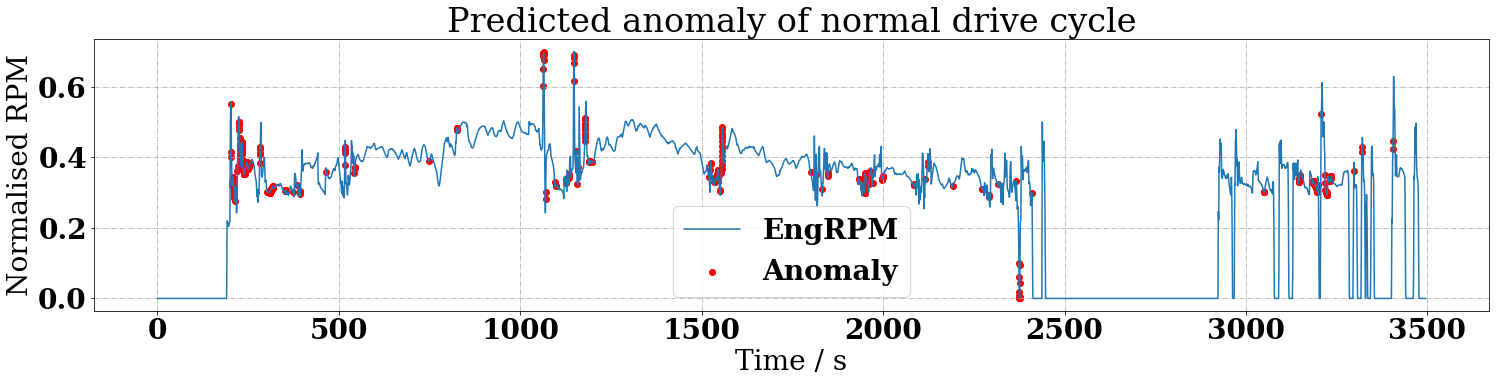

Normal DC anomalous behaviour:  3.7696709585121604 %
Normal DC normal behaviour:  96.23032904148783 %


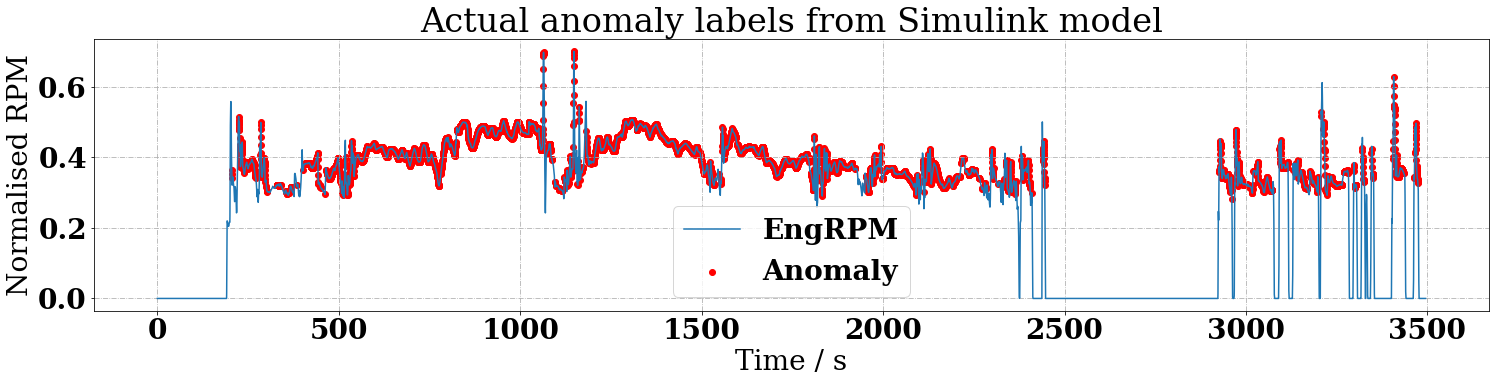

In [85]:
def Anomaly_plot(data, anomaly, alpha, title):
    data = np.mean(data,axis=1)
    plt.figure(figsize=[25,5])
    plt.plot(np.arange(0,int(len(data)*CONFIG.PreProcessing.window_size/100),CONFIG.PreProcessing.window_size/100),data[:,0], label = 'EngRPM')
    plt.scatter(anomaly.index.values*CONFIG.PreProcessing.window_size/100,anomaly.iloc[:,0],marker='o',color = 'red', label = 'Anomaly')
    #plt.fill_between(np.arange(0,len(data)) ,data[:,0] - alpha, data[:,0] + alpha,color='lightskyblue')
    plt.legend()
    plt.grid(linestyle='-.')
    plt.xlabel('Time / s')
    plt.ylabel('Normalised RPM')
    plt.title(title)
    plt.show()

def JudgeAnomaly(data,loss,threshold):
    data = np.mean(data,axis=1)
    sample = pd.DataFrame(data)
    normal = sample[loss<threshold]
    abnormal = sample[loss>=threshold]
    res = np.where(loss >= threshold, 1, 0)
    return normal, abnormal, res

threshold = 0.2
pred_normal, pred_abnormal, pred_res = JudgeAnomaly(x_test, test_mae_loss, threshold)
Anomaly_plot(x_test, pred_abnormal, threshold,'Predicted anomaly of anomalous drive cycle')
print('Anomalous DC anomalous behaviour: ',pred_abnormal.shape[0]*100/x_test.shape[0],'%')
print('Anomalous DC normal behaviour: ',pred_normal.shape[0]*100/x_test.shape[0],'%')

act_normal, act_abnormal, nom_res = JudgeAnomaly(nom, nom_mae_loss, threshold)
Anomaly_plot(nom, act_abnormal, threshold, 'Predicted anomaly of normal drive cycle')
print('Normal DC anomalous behaviour: ',act_abnormal.shape[0]*100/nom.shape[0],'%')
print('Normal DC normal behaviour: ',act_normal.shape[0]*100/nom.shape[0],'%')

act_normal, act_abnormal, nom_res = JudgeAnomaly(nom, mae_loss, threshold)
Anomaly_plot(nom, act_abnormal, threshold, 'Actual anomaly labels from Simulink model')
#print('anomaly detection: ',act_abnormal.shape[0]*100/nom.shape[0],'%')


In [90]:
from sklearn.metrics import roc_auc_score

def Performance(pred_abnormal,pred_normal,act_abnormal,act_normal, pred, nom):
    A = np.array(pred_abnormal.index.values.astype(int))
    B = np.array(act_abnormal.index.values.astype(int))
    TP = len([i for i in B if i in A])
    FP = len([i for i in B if i not in A])

    C = np.array(pred_normal.index.values.astype(int))
    D = np.array(act_normal.index.values.astype(int))
    TN = len([i for i in D if i in C])
    FN = len([i for i in D if i not in C])

    AUC = roc_auc_score(nom, pred)
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = (2*Precision*Recall)/(Precision+Recall)
    return Accuracy, F1, AUC


thresholds = np.arange(0.02,0.25,0.001)
Accuracy = []
F1 = []
AUC = []
for threshold in thresholds:
    pred_normal, pred_abnormal, pred_res = JudgeAnomaly(x_test, test_mae_loss, threshold)
    act_normal, act_abnormal, nom_res = JudgeAnomaly(nom, mae_loss, threshold)
    acc, f1, auc = Performance(pred_abnormal,pred_normal,act_abnormal,act_normal, pred_res, nom_res)
    Accuracy.append(acc*100)
    F1.append(f1*100)
    AUC.append(auc*100)


plt.figure(figsize=(10,8))
plt.plot(thresholds, Accuracy,'r', label ='Accuracy')
plt.plot(thresholds,F1,'b',label = 'F1-score')
plt.plot(thresholds,AUC,'g',label = 'AUC-score')
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.ylim(0,100)
plt.xlim(thresholds[0],thresholds[-1])
plt.title('Threshold vs Model Performance')
plt.legend()
plt.grid(linestyle='-.')
plt.show()

max(Accuracy)

KeyboardInterrupt: 

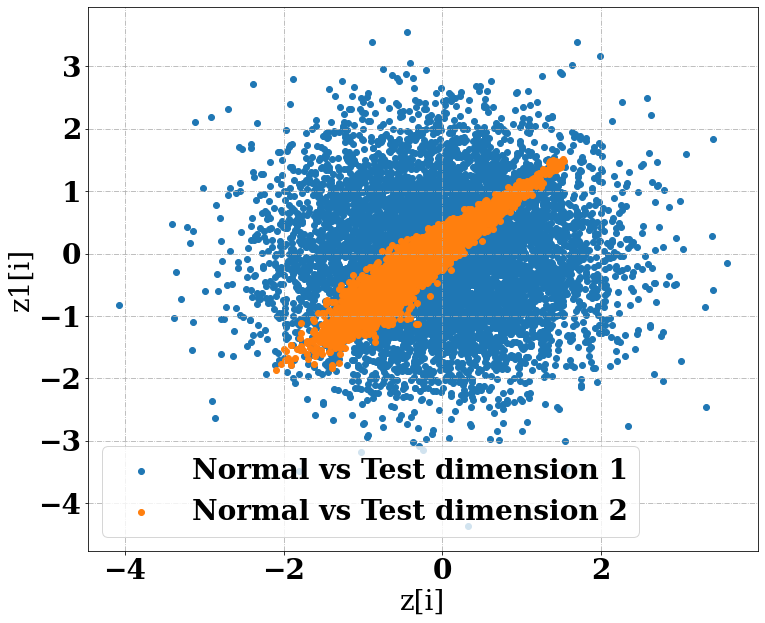

In [91]:
train_data = pd.read_csv('./Dataset/train7.csv')
nom_data = pd.read_csv('./Dataset/DriveCycle4-test-100.csv')
test_data = pd.read_csv('./Dataset/DriveCycle4-test-0.csv')
x_train, x_test, nom, _ = Preprocessing(train_data, test_data, nom_data)


def plot_label_clusters(vae, data, data1):
    # display a 2D plot of the digit classes in the latent space
    _, _, z = vae.encoder.predict(data)
    _, _, z1 = vae.encoder.predict(data1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 1], z1[:, 1],label = 'Normal vs Test dimension 1')
    plt.scatter(z[:, 2], z1[:, 2],label = 'Normal vs Test dimension 2')
    plt.legend()
    plt.xlabel("z[i]")
    plt.ylabel("z1[i]")
    plt.grid(linestyle='-.')
    plt.show()


plot_label_clusters(vae, nom, x_test)

In [93]:
def SaveModel(vae):
    vae.decoder.save('./Model/Lstm-VAE/100Hz_25win_ConvLSTM/decoder_IP_ET')
    vae.encoder.save('./Model/Lstm-VAE/100Hz_25win_ConvLSTM/encoder_IP_ET')

if CONFIG.Models.lstm_VAE.save == True:
    SaveModel(vae)


INFO:tensorflow:Assets written to: ./Model/Lstm-VAE/100Hz_25win_ConvLSTM/decoder_IP_ET\assets


INFO:tensorflow:Assets written to: ./Model/Lstm-VAE/100Hz_25win_ConvLSTM/decoder_IP_ET\assets


INFO:tensorflow:Assets written to: ./Model/Lstm-VAE/100Hz_25win_ConvLSTM/encoder_IP_ET\assets


INFO:tensorflow:Assets written to: ./Model/Lstm-VAE/100Hz_25win_ConvLSTM/encoder_IP_ET\assets
